In [1]:
from scipy import misc, ndimage, signal
from sklearn.model_selection  import train_test_split
import numpy
import numpy as np
import random
import ntpath
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import tensorflow as tf
from tensorflow.keras import optimizers 
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from time import time
import time as tm
import datetime
from operator import itemgetter
import glob
from tensorflow.keras.utils import *
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.utils
from numpy import argmax
import seaborn as sn 

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
"""import tensorflow as tf
!python3 -c 'import tensorflow as tf; print(tf.__version__)'  # for Python 3
!nvidia-smi

physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

#USANDO LA CPU
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

tf.config.list_physical_devices('GPU')

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())"""


'import tensorflow as tf\n!python3 -c \'import tensorflow as tf; print(tf.__version__)\'  # for Python 3\n!nvidia-smi\n\nphysical_devices = tf.config.list_physical_devices(\'GPU\')\nprint("Num GPUs:", len(physical_devices))\n\n#USANDO LA CPU\nimport os\nos.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"\nos.environ[\'CUDA_VISIBLE_DEVICES\'] = \'-1\'\n\nif tf.test.gpu_device_name():\n    print(\'GPU found\')\nelse:\n    print("No GPU found")\n\nprint("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices(\'GPU\')))\n\ntf.config.list_physical_devices(\'GPU\')'

In [3]:
"""!nvcc --version
!conda install -c anaconda scikit-learn -y
!conda install -c anaconda seaborn -y
!conda install -c anaconda pydot -y
!conda install -c anaconda graphviz -y"""

'!nvcc --version\n!conda install -c anaconda scikit-learn -y\n!conda install -c anaconda seaborn -y\n!conda install -c anaconda pydot -y\n!conda install -c anaconda graphviz -y'

In [2]:
T3 = 3;
def Tanh3(x):
    tanh3 = K.tanh(x)*T3
    return tanh3

In [3]:
#X = np.load('../InpactorDB/InpactorDB_v1.fasta.npy')
#Y = np.load('../InpactorDB/InpactorDB_v1.fasta_labels.npy')

X = np.load('../InpactorDB/repbase_LTRs_I_3dom.fasta.lineages_final.clean.npy')
Y = np.load('../InpactorDB/repbase_LTRs_I_3dom.fasta.lineages_final.clean_lables.npy')

In [4]:
print(X.shape)
print(Y.shape)

(2842, 5, 22576)
(2842, 1)


In [5]:
#data split: 80% train, 10% dev and 10% test
validation_size = 0.2
seed = 7
X_train, X_test_dev, Y_train, Y_test_dev = train_test_split(X, Y, test_size=validation_size, random_state=seed)

X_dev, X_test, Y_dev, Y_test = train_test_split(X_test_dev, Y_test_dev, test_size=0.5, random_state=seed)

print(X_train.shape)
print(Y_train.shape)
print(X_dev.shape)
print(Y_dev.shape)
print(X_test.shape)
print(Y_test.shape)

X = None
Y = None

(2273, 5, 22576)
(2273, 1)
(284, 5, 22576)
(284, 1)
(285, 5, 22576)
(285, 1)


In [6]:
path_log_base = './logs_CNN'

In [7]:
def metrics(Y_validation,predictions):
    
    classes = len(numpy.unique(Y_validation))
    print('Accuracy:', accuracy_score(Y_validation, predictions))
    print('F1 score:', f1_score(Y_validation, predictions,average='weighted'))
    print('Recall:', recall_score(Y_validation, predictions,average='weighted'))
    print('Precision:', precision_score(Y_validation, predictions, average='weighted'))
    print('\n clasification report:\n', classification_report(Y_validation, predictions))
    print('\n confusion matrix:\n',confusion_matrix(Y_validation, predictions))
    #Creamos la matriz de confusión
    snn_cm = confusion_matrix(Y_validation, predictions)

    # Visualizamos la matriz de confusión
    snn_df_cm = pd.DataFrame(snn_cm, range(classes), range(classes))  
    plt.figure(figsize = (20,14))  
    sn.set(font_scale=1.4) #for label size  
    sn.heatmap(snn_df_cm, annot=True, annot_kws={"size": 12}) # font size  
    plt.show()

In [8]:
def train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size, epochs, model_name=""):
    start_time = tm.time()
    log_dir=path_log_base+"/"+model_name+"_"+str(datetime.datetime.now().isoformat()[:19].replace("T", "_").replace(":","-"))
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir, histogram_freq=1)
    filepath = log_dir+"/saved-model-{epoch:03d}-{val_accuracy:.4f}.hdf5"
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=False, mode='max')
    model.reset_states()
    
    #VALORES EN TRAIN TEST Y VALIDACIÓN INICIALES, GRÁFICOS
    global lossTEST
    global accuracyTEST
    global lossTRAIN
    global accuracyTRAIN
    global lossVALID
    global accuracyVALID
    lossTEST,accuracyTEST   = model.evaluate(X_test, y_test,verbose=None)
    lossTRAIN,accuracyTRAIN = model.evaluate(X_train, y_train,verbose=None)
    lossVALID,accuracyVALID = model.evaluate(X_valid, y_valid,verbose=None)

    global history
    global model_Name
    global log_Dir
    model_Name = model_name
    log_Dir = log_dir
    
    history=model.fit(X_train, y_train, epochs=epochs, 
                      callbacks=[tensorboard,checkpoint], 
                      batch_size=batch_size,validation_data=(X_valid, y_valid),verbose=1)
    
    metrics = model.evaluate(X_test, y_test, verbose=0)
     
    TIME = tm.time() - start_time
    print("Time "+model_name+" = %s [seconds]" % TIME)
    
    print("\n")
    print(log_dir)
    return {k:v for k,v in zip (model.metrics_names, metrics)}

In [9]:
def Final_Results_Test(PATH_trained_models):
    global AccTest
    global LossTest
    AccTest = []
    LossTest= [] 
    B_accuracy = 0 #B --> Best
    for filename in sorted(os.listdir(PATH_trained_models)):
        if filename != ('train') and filename != ('validation'):
            print(filename)
            model = tf.keras.models.load_model(PATH_trained_models+'/'+filename, custom_objects={'Tanh3':Tanh3})
            loss,accuracy = model.evaluate(X_test, y_test,verbose=0)
            print(f'Loss={loss:.4f} y Accuracy={accuracy:0.4f}'+'\n')
            BandAccTest  = accuracy
            BandLossTest = loss
            AccTest.append(BandAccTest)    #Valores de la precisión en Test, para graficar junto a valid y train
            LossTest.append(BandLossTest)  #Valores de la perdida en Test, para graficar junto a valid y train
            
            if accuracy > B_accuracy:
                B_accuracy = accuracy
                B_loss = loss
                B_name = filename
    
    print("\n\nBest")
    print(B_name)
    print(f'Loss={B_loss:.4f} y Accuracy={B_accuracy:0.4f}'+'\n')

In [10]:
def graphics(history, AccTest, LossTest, log_Dir, model_Name, lossTEST, lossTRAIN, lossVALID, accuracyTEST, accuracyTRAIN, accuracyVALID):
    numbers=AccTest
    numbers_sort = sorted(enumerate(numbers), key=itemgetter(1),  reverse=True)
    for i in range(int(len(numbers)*(0.05))): #5% Del total de las épocas
        index, value = numbers_sort[i]
        print("Test Accuracy {}, Época:{}\n".format(value, index+1))
    
    print("")
    
    numbers=history.history['accuracy']
    numbers_sort = sorted(enumerate(numbers), key=itemgetter(1),  reverse=True)
    for i in range(int(len(numbers)*(0.05))): #5% Del total de las épocas
        index, value = numbers_sort[i]
        print("Train Accuracy {}, Época:{}\n".format(value, index+1))
    
    print("")
    
    numbers=history.history['val_accuracy']
    numbers_sort = sorted(enumerate(numbers), key=itemgetter(1),  reverse=True)
    for i in range(int(len(numbers)*(0.05))): #5% Del total de las épocas
        index, value = numbers_sort[i]
        print("Validation Accuracy {}, Época:{}\n".format(value, index+1))

    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(10, 10))
        #Plot training & validation accuracy values
        plt.plot(np.concatenate([np.array([accuracyTRAIN]),np.array(history.history['accuracy'])],axis=0))
        plt.plot(np.concatenate([np.array([accuracyVALID]),np.array(history.history['val_accuracy'])],axis=0))
        plt.plot(np.concatenate([np.array([accuracyTEST]),np.array(AccTest)],axis=0)) #Test
        plt.title('Accuracy Vs Epoch')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation', 'Test'], loc='upper left')
        plt.grid('on')
        #plt.savefig(path_img_base+'/Accuracy_GBRAS-Net_'+model_Name+'.eps', format='eps')
        #plt.savefig(path_img_base+'/Accuracy_GBRAS-Net_'+model_Name+'.svg', format='svg')
        #plt.savefig(path_img_base+'/Accuracy_GBRAS-Net_'+model_Name+'.pdf', format='pdf')     
        #plt.show()
        
        plt.figure(figsize=(10, 10))
        #Plot training & validation loss values
        plt.plot(np.concatenate([np.array([lossTRAIN]),np.array(history.history['loss'])],axis=0))
        plt.plot(np.concatenate([np.array([lossVALID]),np.array(history.history['val_loss'])],axis=0))
        plt.plot(np.concatenate([np.array([lossTEST]),np.array(LossTest)],axis=0)) #Test
        plt.title('Loss Vs Epoch')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation', 'Test'], loc='upper left')
        plt.grid('on')
        #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.eps', format='eps')
        #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.svg', format='svg')
        #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.pdf', format='pdf') 
        plt.show() 

In [11]:
def Final_Results_Test(PATH_trained_models):
    global AccTest
    global LossTest
    AccTest = []
    LossTest= [] 
    B_accuracy = 0 #B --> Best
    for filename in sorted(os.listdir(PATH_trained_models)):
        if filename != ('train') and filename != ('validation'):
            print(filename)
            model = tf.keras.models.load_model(PATH_trained_models+'/'+filename, custom_objects={'Tanh3':Tanh3})
            loss,accuracy = model.evaluate(X_test, one_hot_labels_test,verbose=0)
            print(f'Loss={loss:.4f} y Accuracy={accuracy:0.4f}'+'\n')
            BandAccTest  = accuracy
            BandLossTest = loss
            AccTest.append(BandAccTest)    #Valores de la precisión en Test, para graficar junto a valid y train
            LossTest.append(BandLossTest)  #Valores de la perdida en Test, para graficar junto a valid y train
            
            if accuracy > B_accuracy:
                B_accuracy = accuracy
                B_loss = loss
                B_name = filename
    
    print("\n\nBest")
    print(B_name)
    print(f'Loss={B_loss:.4f} y Accuracy={B_accuracy:0.4f}'+'\n')

In [12]:
def train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size, epochs, model_name=""):
    start_time = tm.time()
    log_dir=path_log_base+"/"+model_name+"_"+str(datetime.datetime.now().isoformat()[:19].replace("T", "_").replace(":","-"))
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir, histogram_freq=1)
    filepath = log_dir+"/saved-model-{epoch:03d}-{val_accuracy:.4f}.hdf5"
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=False, mode='max')
    model.reset_states()
    
    #VALORES EN TRAIN TEST Y VALIDACIÓN INICIALES, GRÁFICOS
    global lossTEST
    global accuracyTEST
    global lossTRAIN
    global accuracyTRAIN
    global lossVALID
    global accuracyVALID
    lossTEST,accuracyTEST   = model.evaluate(X_test, y_test,verbose=None)
    lossVALID,accuracyVALID = model.evaluate(X_valid, y_valid,verbose=None)
    lossTRAIN,accuracyTRAIN = model.evaluate(X_train, y_train,verbose=None)
    
    global history
    global model_Name
    global log_Dir
    model_Name = model_name
    log_Dir = log_dir
    
    history=model.fit(X_train, y_train, epochs=epochs, 
                      callbacks=[tensorboard,checkpoint], 
                      batch_size=batch_size,validation_data=(X_valid, y_valid),verbose=1)
    
    metrics = model.evaluate(X_test, y_test, verbose=0)
     
    TIME = tm.time() - start_time
    print("Time "+model_name+" = %s [seconds]" % TIME)
    
    print("\n")
    print(log_dir)
    return {k:v for k,v in zip (model.metrics_names, metrics)}

In [13]:
X_train.shape

(2273, 5, 22576)

In [14]:
def TERL():
    tf.keras.backend.clear_session()

    # FNN implemented by Da Cruz, et al.

    # Inputs
    inputs = tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2], 1), name="input_1")
    # layer 1
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(inputs)
    layers = tf.keras.layers.Conv2D(64, (5, 20), strides=(1,1), activation="relu", use_bias=True)(layers)
    layers = tf.keras.layers.AveragePooling2D((1, 10), strides= (1, 10))(layers)
    # layer 2
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.Conv2D(32, (1, 20), strides=(1,1), activation="relu", use_bias=True)(layers)
    layers = tf.keras.layers.AveragePooling2D((1, 15), strides= (1, 15))(layers)
    # layer 3
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.Conv2D(32, (1, 35), strides=(1,1), activation="relu", use_bias=True)(layers)
    layers = tf.keras.layers.AveragePooling2D((1, 15), strides= (1, 15))(layers)
    # layer 4
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.Dense(1000,activation="relu")(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.Dense(500,activation="relu")(layers)
    # layer 5
    predictions = tf.keras.layers.Dense(21, activation="softmax", name="output_1")(layers)
    # model generation
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    # optimizer
    opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    # loss function
    loss_fn = tf.keras.losses.CategoricalCrossentropy()
    # Compile model
    #model.compile(loss=loss_fn, optimizer=opt, metrics=['acc', 'AUC', 'mse','mae','mape'])
    model.compile(loss=loss_fn, optimizer=opt, metrics=['accuracy'])
    return model

In [15]:
def Inpactor_CNN_Net():
    tf.keras.backend.clear_session()

    # FNN implemented by Da Cruz, et al.

    # Inputs
    inputs = tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2], 1), name="input_1")
    # layer 1
    layers = tf.keras.layers.Conv2D(64, (5, 20), strides=(1,1), activation="relu", use_bias=True)(inputs)
    layers = tf.keras.layers.AveragePooling2D((1, 10), strides= (1, 10))(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    # layer 2
    layers = tf.keras.layers.Conv2D(32, (1, 20), strides=(1,1), activation="relu", use_bias=True)(layers)
    layers = tf.keras.layers.AveragePooling2D((1, 15), strides= (1, 15))(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    # layer 3
    layers = tf.keras.layers.Conv2D(32, (1, 35), strides=(1,1), activation="relu", use_bias=True)(layers)
    layers = tf.keras.layers.AveragePooling2D((1, 15), strides= (1, 15))(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    # layer 4
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(1000,activation="relu")(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.Dense(500,activation="relu")(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    # layer 5
    predictions = tf.keras.layers.Dense(21, activation="softmax", name="output_1")(layers)
    # model generation
    model = tf.keras.Model(inputs = inputs, outputs=(predictions + 1e-8))
    # optimizer
    opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    # loss function
    loss_fn = tf.keras.losses.CategoricalCrossentropy()
    # Compile model
    #model.compile(loss=loss_fn, optimizer=opt, metrics=['acc', 'AUC', 'mse','mae','mape'])
    model.compile(loss=loss_fn, optimizer=opt, metrics=['accuracy'])
    return model

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 22576, 1)]     0         
_________________________________________________________________
batch_normalization (BatchNo (None, 5, 22576, 1)       3         
_________________________________________________________________
conv2d (Conv2D)              (None, 1, 22557, 64)      6464      
_________________________________________________________________
average_pooling2d (AveragePo (None, 1, 2255, 64)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 2255, 64)       192       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 2236, 32)       40992     
_________________________________________________________________
average_pooling2d_1 (Average (None, 1, 149, 32)        0     

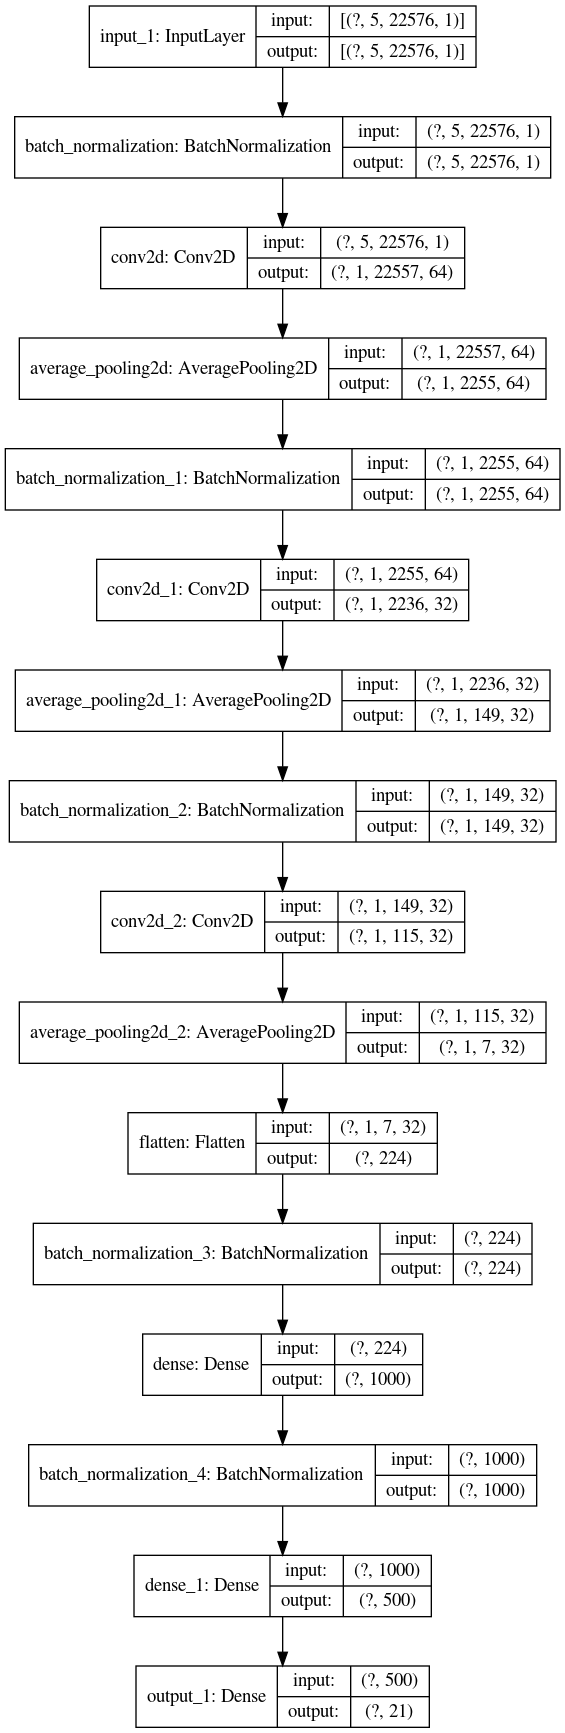

In [15]:
model = TERL()
# summarize layers
print(model.summary())
tf.keras.utils.plot_model(model, show_shapes=True)

In [16]:
X_train.shape

(2273, 5, 22576)

In [17]:
one_hot_labels_train = tf.keras.utils.to_categorical(Y_train, num_classes=21)
one_hot_labels_validation = tf.keras.utils.to_categorical(Y_dev, num_classes=21)
one_hot_labels_test = tf.keras.utils.to_categorical(Y_test, num_classes=21)

In [18]:
history=model.fit(X_train, one_hot_labels_train, epochs=100, 
                      batch_size=32,validation_data=(X_dev, one_hot_labels_validation),verbose=1)

Epoch 1/100
72/72 [==============================] - 2s 33ms/step - loss: 1.7454 - accuracy: 0.5266 - val_loss: 28.3055 - val_accuracy: 0.0704
Epoch 2/100
72/72 [==============================] - 2s 25ms/step - loss: 2.1691 - accuracy: 0.2934 - val_loss: 2.3014 - val_accuracy: 0.3099
Epoch 3/100
72/72 [==============================] - 2s 25ms/step - loss: 2.0372 - accuracy: 0.2934 - val_loss: 9.3035 - val_accuracy: 0.0704
Epoch 4/100
72/72 [==============================] - 2s 25ms/step - loss: 2.0408 - accuracy: 0.2912 - val_loss: 2.7463 - val_accuracy: 0.3099
Epoch 5/100
72/72 [==============================] - 2s 25ms/step - loss: 2.0349 - accuracy: 0.2824 - val_loss: 6.7160 - val_accuracy: 0.0704
Epoch 6/100
72/72 [==============================] - 2s 25ms/step - loss: 2.0389 - accuracy: 0.2824 - val_loss: 11.0509 - val_accuracy: 0.0704
Epoch 7/100
72/72 [==============================] - 2s 25ms/step - loss: 2.0352 - accuracy: 0.2934 - val_loss: 6.6380 - val_accuracy: 0.0704
Epoc

72/72 [==============================] - 2s 25ms/step - loss: 2.0213 - accuracy: 0.2934 - val_loss: 8.5323 - val_accuracy: 0.0704
Epoch 59/100
72/72 [==============================] - 2s 25ms/step - loss: 2.0230 - accuracy: 0.2934 - val_loss: 33.9932 - val_accuracy: 0.0704
Epoch 60/100
72/72 [==============================] - 2s 25ms/step - loss: 2.0237 - accuracy: 0.2934 - val_loss: 12.6287 - val_accuracy: 0.3099
Epoch 61/100
72/72 [==============================] - 2s 25ms/step - loss: 2.0233 - accuracy: 0.2934 - val_loss: 32.2072 - val_accuracy: 0.0704
Epoch 62/100
72/72 [==============================] - 2s 25ms/step - loss: 2.0237 - accuracy: 0.2934 - val_loss: 9.5985 - val_accuracy: 0.0599
Epoch 63/100
72/72 [==============================] - 2s 25ms/step - loss: 2.0246 - accuracy: 0.2934 - val_loss: 12.2883 - val_accuracy: 0.3099
Epoch 64/100
72/72 [==============================] - 2s 25ms/step - loss: 2.0352 - accuracy: 0.2934 - val_loss: 16.2162 - val_accuracy: 0.0704
Epoch 6

In [23]:
# Fit the model
#train(model, X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2],1), one_hot_labels_train, X_dev.reshape(X_dev.shape[0], X_dev.shape[1], X_dev.shape[2],1), one_hot_labels_validation, X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2],1), one_hot_labels_test, 16, 100, "TERL")
train(model, X_train, one_hot_labels_train, X_dev, one_hot_labels_validation, X_test, one_hot_labels_test, 16, 100, "TERL")
Final_Results_Test(log_Dir) 

Epoch 1/100
2019/2020 [============================>.] - ETA: 0s - loss: 2.1424 - accuracy: 0.3024

InvalidArgumentError: Nan in summary histogram for: conv2d/kernel_0 [Op:WriteHistogramSummary]

In [ ]:
# plot metrics
plt.plot(history.history['accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Epoch vs Accuracy')
plt.show()

#GRÁFICOS DE LAS TRES CURVAS TRAIN TEST Y VALIDACIÓN
graphics(history, AccTest, LossTest, log_Dir, model_Name, lossTEST, lossTRAIN, lossVALID, accuracyTEST, accuracyTRAIN, accuracyVALID)


In [ ]:
scores = model.evaluate(X_train, one_hot_labels_train, verbose=0)
print("Baseline Error train: %.2f%%" % (100-scores[1]*100))

scores = model.evaluate(X_dev, one_hot_labels_validation, verbose=0)
print("Baseline Error dev: %.2f%%" % (100-scores[1]*100))

scores = model.evaluate(X_test, one_hot_labels_test, verbose=0)
print("Baseline Error test: %.2f%%" % (100-scores[1]*100))

predictions = model.predict(X_train)

metrics(Y_train, [argmax(x) for x in predictions])

predictions = model.predict(X_dev)

metrics(Y_dev, [argmax(x) for x in predictions])

predictions = model.predict(X_test)

metrics(Y_test, [argmax(x) for x in predictions])